In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pickle
from pprint import pprint
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc


%matplotlib inline

In [2]:
fs_dropouts = pd.read_csv('data/9th_grade_dropouts.csv', index_col='sid')

In [3]:
fs_dropouts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52933 entries, 2 to 111990
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dropout           52933 non-null  int64  
 1   male              52933 non-null  float64
 2   race_num          52933 non-null  int64  
 3   math_ss           52933 non-null  float64
 4   read_ss           52933 non-null  float64
 5   gifted            52933 non-null  int64  
 6   ever_alternative  52933 non-null  int64  
 7   iep               52933 non-null  int64  
 8   pct_days_absent   52933 non-null  float64
 9   gpa               52933 non-null  float64
 10  frpl              52933 non-null  float64
 11  ell               52933 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 5.3 MB


OK, let's train/test/split our data

In [4]:
X = fs_dropouts.copy()

In [5]:
y = X.pop('dropout')
y

sid
2         0
5         0
12        1
13        0
14        0
         ..
111984    0
111985    0
111986    0
111988    1
111990    0
Name: dropout, Length: 52933, dtype: int64

In [6]:
X

,male,race_num,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell
sid,,,,,,,,,,,
2,0.0,0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0
5,0.0,0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0
12,0.0,0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0
13,0.0,0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0
14,1.0,0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,1,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0
111985,0.0,0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0
111986,1.0,0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Baseline Random Forest Classifier to determine Feature Importance

In [8]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [9]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.854345088161209

In [10]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12263,   626],
       [ 1687,  1304]])

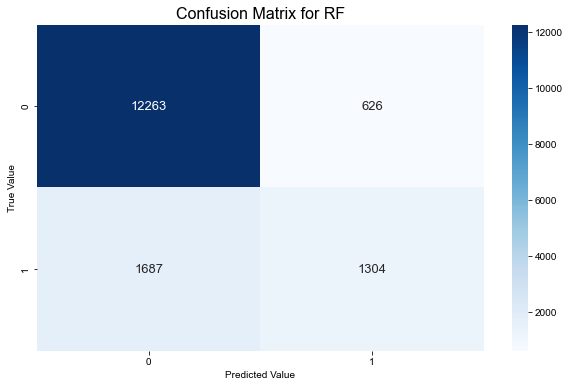

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest.png')

In [12]:
score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12889
     Dropout       0.68      0.44      0.53      2991

    accuracy                           0.85     15880
   macro avg       0.78      0.69      0.72     15880
weighted avg       0.84      0.85      0.84     15880



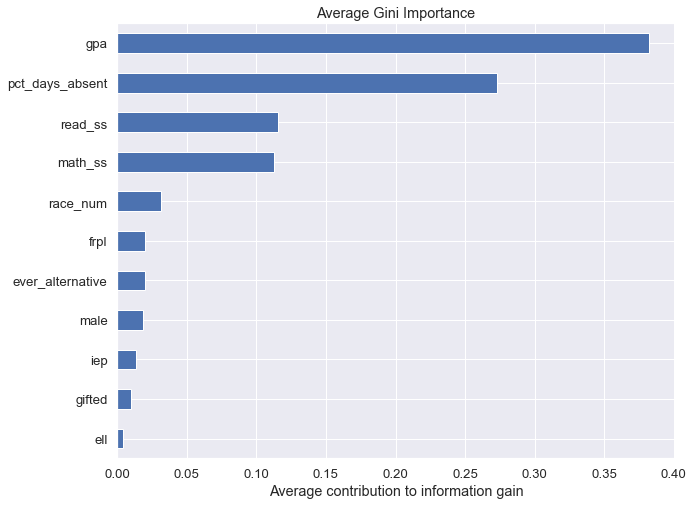

In [13]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [75]:
feat_scores[0]

ell                 0.003902
gifted              0.009701
iep                 0.013748
male                0.018512
ever_alternative    0.019851
frpl                0.020137
race_num            0.031277
math_ss             0.113049
read_ss             0.115430
pct_days_absent     0.272659
gpa                 0.381734
dtype: float64

Number of features for 95% importance: 9


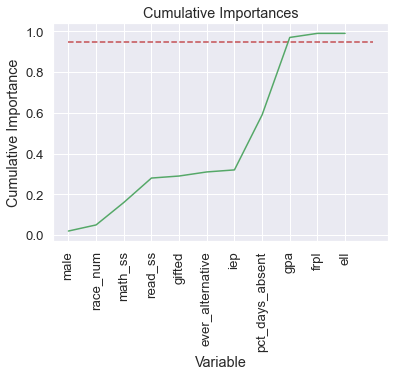

In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]

# List of features sorted from most to least important
x_values = list(range(len(importances)))
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');


# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

This is not the best...Let's see if we can improve it. I want my dropout precision to be better! 

# Random Forest Classifier Utilizing Oversampling of Minority(Dropout) Class

In [15]:
#Because class is imbalanced, let's try doing some minority class oversampling
os = SMOTE(random_state=0)
X_os, y_os = os.fit_sample(X_train, y_train)
print("length of oversampled data is ",len(X_os))
print("number of negative case in oversampled data",len(y_os == 0))
print("Proportion of no subscription data in oversampled data is ",len(y_os==0)/len(X_os))

length of oversampled data is  60318
number of negative case in oversampled data 60318
Proportion of no subscription data in oversampled data is  1.0


In [16]:
X_os.shape

(60318, 11)

In [17]:
X_train.shape

(37053, 11)

In [18]:
rf.fit(X_os,y_os)
y_pred_os = rf.predict(X_test)
rf.score(X_test,y_test)



0.8254408060453401

In [19]:
cm_rf = confusion_matrix(y_test,y_pred_os)
cm_rf

array([[11428,  1461],
       [ 1311,  1680]])

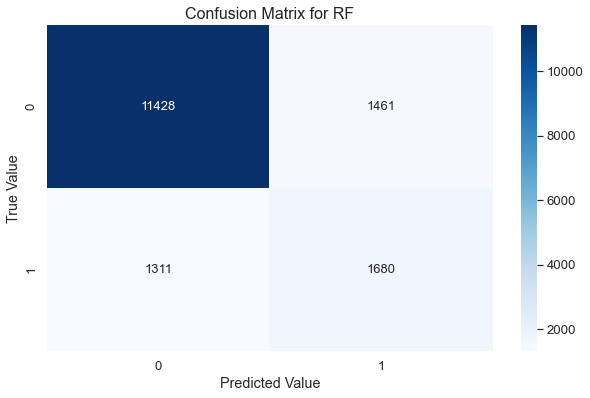

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-with-SMOTE.png')

In [21]:
os_score = classification_report(y_test,y_pred_os, target_names = ['Not Dropout', 'Dropout'])
print(os_score)

              precision    recall  f1-score   support

 Not Dropout       0.90      0.89      0.89     12889
     Dropout       0.53      0.56      0.55      2991

    accuracy                           0.83     15880
   macro avg       0.72      0.72      0.72     15880
weighted avg       0.83      0.83      0.83     15880



# Removing Low Importance Features

In [22]:
lowest_features = feat_scores.index[:3]

In [23]:
X_new = X.drop(lowest_features, axis=1)

In [24]:
X

,male,race_num,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell
sid,,,,,,,,,,,
2,0.0,0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0
5,0.0,0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0
12,0.0,0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0
13,0.0,0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0
14,1.0,0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,1,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0
111985,0.0,0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0
111986,1.0,0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0


In [25]:
X_new

,male,race_num,math_ss,read_ss,ever_alternative,pct_days_absent,gpa,frpl
sid,,,,,,,,
2,0.0,0,-1.0,-1.0,1,10.664031,1.230000,1.0
5,0.0,0,18.0,46.0,0,0.969005,2.822795,1.0
12,0.0,0,18.0,35.0,1,4.746706,0.330000,0.0
13,0.0,0,48.0,80.0,0,6.850071,2.985000,1.0
14,1.0,0,18.0,30.0,0,5.802631,2.118500,1.0
...,...,...,...,...,...,...,...,...
111984,1.0,1,34.0,44.0,1,9.833898,2.079800,1.0
111985,0.0,0,23.0,51.0,1,2.291429,3.443500,0.0
111986,1.0,0,4.0,18.0,0,7.766962,1.695142,1.0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [27]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [28]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.8532115869017632

In [29]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12258,   631],
       [ 1700,  1291]])

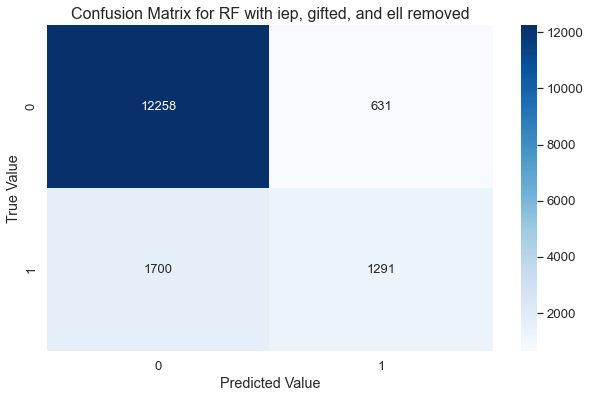

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF with iep, gifted, and ell removed', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-removed-features.png')

In [31]:
new_score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(new_score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12889
     Dropout       0.67      0.43      0.53      2991

    accuracy                           0.85     15880
   macro avg       0.77      0.69      0.72     15880
weighted avg       0.84      0.85      0.84     15880



In [32]:
X

,male,race_num,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell
sid,,,,,,,,,,,
2,0.0,0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0
5,0.0,0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0
12,0.0,0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0
13,0.0,0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0
14,1.0,0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,1,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0
111985,0.0,0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0
111986,1.0,0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0


In [33]:
from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


# Random Forest Classifier using only 2 most important features

In [34]:
X_5 = X[['gpa', 'pct_days_absent']]
X_5

,gpa,pct_days_absent
sid,,
2,1.230000,10.664031
5,2.822795,0.969005
12,0.330000,4.746706
13,2.985000,6.850071
14,2.118500,5.802631
...,...,...
111984,2.079800,9.833898
111985,3.443500,2.291429
111986,1.695142,7.766962


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_5, y, test_size=0.3, random_state=0)
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [36]:
rf.score(X_test,y_test)


0.8382241813602015

In [37]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf


array([[12121,   768],
       [ 1801,  1190]])

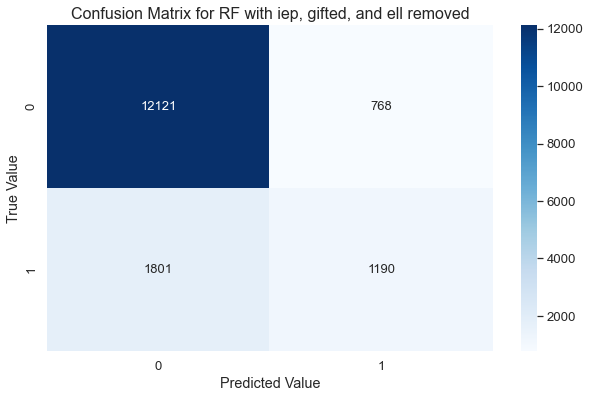

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF with iep, gifted, and ell removed', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-5-features.png')

In [39]:
new_score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(new_score)

              precision    recall  f1-score   support

 Not Dropout       0.87      0.94      0.90     12889
     Dropout       0.61      0.40      0.48      2991

    accuracy                           0.84     15880
   macro avg       0.74      0.67      0.69     15880
weighted avg       0.82      0.84      0.82     15880



# Tuning model hyperparameters using CV Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [41]:
# Use the random grid to search for best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# First create the base model to tune
rf = RandomForestClassifier(n_estimators = 500)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 78.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=500),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [42]:
pickle.dump(rf_random, open('data/rf_random_cv.pkl', 'wb'))



In [43]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [44]:
best_rf = RandomForestClassifier(n_estimators=1600,
 min_samples_split=5,
 min_samples_leaf=1,
 max_features='auto',
 max_depth=10,
 bootstrap=True)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=1600)

In [45]:
best_rf_y_pred = best_rf.predict(X_test)

In [46]:
best_rf.score(X_test,y_test)

0.8599496221662468

In [47]:
cm_rf = confusion_matrix(y_test,best_rf_y_pred)
cm_rf

array([[12394,   495],
       [ 1729,  1262]])

# Evaluating Model Performance Based on Threshold value

In [48]:
threshold = [0, 0.10, 0.25, 0.50, 0.75, 1]

predicted = best_rf.predict_proba(X_test)
predicted

array([[0.86849754, 0.13150246],
       [0.75025895, 0.24974105],
       [0.61053256, 0.38946744],
       ...,
       [0.93824175, 0.06175825],
       [0.86112667, 0.13887333],
       [0.94064222, 0.05935778]])

In [49]:
predicted[:,1] #predicted probability that this student will dropout

array([0.13150246, 0.24974105, 0.38946744, ..., 0.06175825, 0.13887333,
       0.05935778])

In [50]:
proba_dropouts = predicted[:,1] 
proba_dropouts > threshold[1]

array([ True,  True,  True, ..., False,  True, False])

In [76]:
for i in range(len(threshold)):
    y_pred_thresh = (predicted[:,1] >= threshold[i]).astype('int')


    thresh_scores = classification_report(y_test,y_pred_thresh, target_names = ['Not Dropout', 'Dropout'])
    #print(round(accuracy,4,)*100, "%")
    confusion_mat = confusion_matrix(y_test,y_pred_thresh)
    print('Threshold value:', threshold[i])
    print(thresh_scores)
    print(confusion_mat)

/Users/kiara/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold value: 0
              precision    recall  f1-score   support

 Not Dropout       0.00      0.00      0.00     12889
     Dropout       0.19      1.00      0.32      2991

    accuracy                           0.19     15880
   macro avg       0.09      0.50      0.16     15880
weighted avg       0.04      0.19      0.06     15880

[[    0 12889]
 [    0  2991]]
Threshold value: 0.1
              precision    recall  f1-score   support

 Not Dropout       0.95      0.61      0.74     12889
     Dropout       0.34      0.86      0.49      2991

    accuracy                           0.66     15880
   macro avg       0.65      0.74      0.62     15880
weighted avg       0.84      0.66      0.70     15880

[[7878 5011]
 [ 407 2584]]
Threshold value: 0.25
              precision    recall  f1-score   support

 Not Dropout       0.91      0.86      0.89     12889
     Dropout       0.52      0.65      0.58      2991

    accuracy                           0.82     15880
   macro

LOOK AT THAT RECALL FOR THRESHOLD 25%!!!!! 

In [52]:
proba_dropouts

array([0.13150246, 0.24974105, 0.38946744, ..., 0.06175825, 0.13887333,
       0.05935778])

In [53]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
best_rf_auc = roc_auc_score(y_test, proba_dropouts)

In [54]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Optimized Random Forest: ROC AUC=%.3f' % (best_rf_auc))

No Skill: ROC AUC=0.500
Optimized Random Forest: ROC AUC=0.842


# Using ROC Curve to Evaluate Model

In [55]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
best_rf_fpr, best_rf_tpr, thresholds = roc_curve(y_test, proba_dropouts)

In [56]:
optimal_idx = np.argmax(best_rf_tpr - best_rf_fpr)
optimal_threshold = thresholds[optimal_idx]

In [57]:
optimal_threshold #this would capture the most true dropouts

0.1703146718616941

In [58]:
best_rf_fpr[optimal_idx]

0.22530840251377143

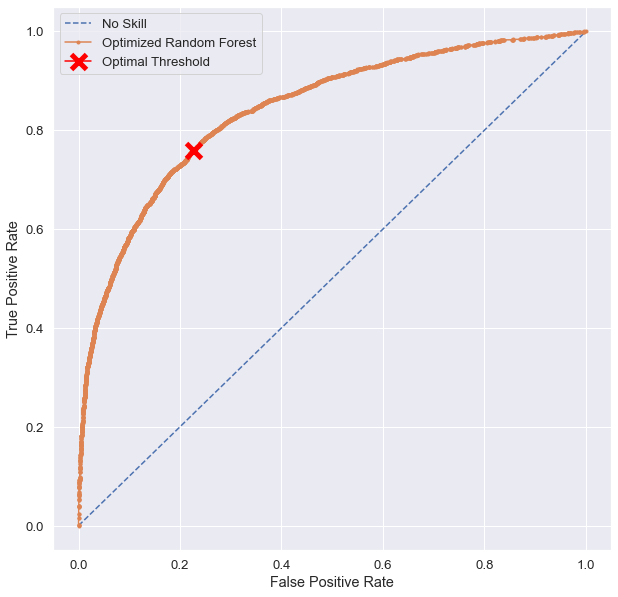

In [59]:
plt.figure(figsize=(10,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(best_rf_fpr, best_rf_tpr, marker='.', label='Optimized Random Forest')
plt.plot(best_rf_fpr[optimal_idx], best_rf_tpr[optimal_idx], marker='x', markersize=15, mew=5, c='red', label='Optimal Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

# Using Precision-Recall Curve to Evaluate Model

In [60]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, proba_dropouts)
auc = auc(recall, precision)

In [61]:
best_rf_precision, best_rf_recall, _ = precision_recall_curve(y_test, proba_dropouts)
#best_rf_f1, best_rf_auc = f1_score(y_test, best_rf_y_pred), auc(best_rf_recall, best_rf_precision)

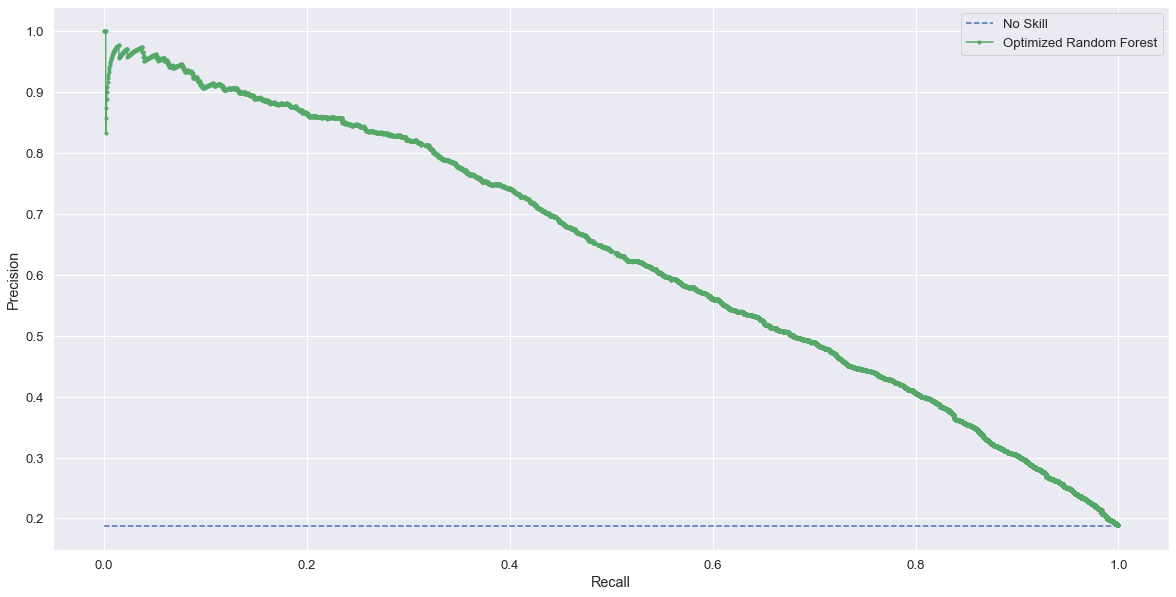

In [62]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize=(20,10))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(best_rf_recall[optimal_idx], best_rf_precision[optimal_idx], marker='X')
plt.plot(best_rf_recall, best_rf_precision, marker='.', label='Optimized Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [63]:
best_rf_y_pred = best_rf.predict(X_test)

# Comparing Model built with 2 Features with the 5 Feature Model

In [64]:
#Ok, let's do one final thing: just 2 x cols, optimized rf, threshold of .75
X_2 = X[['pct_days_absent', 'gpa']]
X_2

,pct_days_absent,gpa
sid,,
2,10.664031,1.230000
5,0.969005,2.822795
12,4.746706,0.330000
13,6.850071,2.985000
14,5.802631,2.118500
...,...,...
111984,9.833898,2.079800
111985,2.291429,3.443500
111986,7.766962,1.695142


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.3, random_state=0)

In [71]:
best_rf.fit(X_train,y_train)
y_pred_os = best_rf.predict(X_test)
best_rf.score(X_test,y_test)

0.8551007556675063

In [72]:
cm_rf = confusion_matrix(y_test,y_pred_os)
cm_rf

array([[12384,   505],
       [ 1796,  1195]])

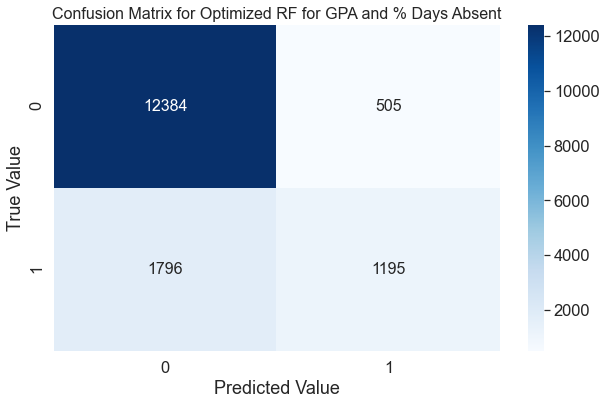

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 16})
sns.set(font_scale=1.5) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for Optimized RF for GPA and % Days Absent', fontsize = 16)
plt.savefig('confusion-matrix-optimized-rf-gpa-and-pct.png')

In [74]:
score = classification_report(y_test, y_pred_os, target_names = ['Not Dropout', 'Dropout'])
print(score)

              precision    recall  f1-score   support

 Not Dropout       0.87      0.96      0.91     12889
     Dropout       0.70      0.40      0.51      2991

    accuracy                           0.86     15880
   macro avg       0.79      0.68      0.71     15880
weighted avg       0.84      0.86      0.84     15880



In conclusion, the random forest model, tuned with hyperparameter from the CV serach, trained and fit on the 5 most important features, and with a threshold of .25 performed the best in terms of accruacy and recall. 